In [228]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.imputation import MeanMedianImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from utils import ScalerDf, Kmeans_
import joblib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sobre el Datase
Este caso requiere desarrollar una segmentación de clientes para definir una estrategia de marketing. El conjunto de datos de muestra resume el comportamiento de uso de aproximadamente 9000 titulares de tarjetas de crédito activos durante los últimos 6 meses. El archivo está a nivel de cliente y contiene 18 variables de comportamiento.

- **CUST_ID**: Identificación del titular de la tarjeta de crédito (Categórica)
- **BALANCE**: Saldo restante en la cuenta para realizar compras.
- **BALANCE_FREQUENCY**: Con qué frecuencia se actualiza el saldo, puntuación entre 0 y 1 (1 = actualizado con frecuencia, 0 = no actualizado con frecuencia).
- **PURCHASES**: Monto de las compras realizadas desde la cuenta.
- **ONEOFF_PURCHASES**: Monto máximo de compra realizado de una sola vez.
- **INSTALLMENTS_PURCHASES**: Monto de compra realizado a plazos.
- **CASH_ADVANCE**: Dinero en efectivo otorgado por el usuario.
- **PURCHASES_FREQUENCY**: Con qué frecuencia se realizan las compras, puntuación entre 0 y 1 (1 = compras frecuentes, 0 = compras no frecuentes).
- **ONEOFFPURCHASESFREQUENCY**: Con qué frecuencia se realizan compras de una sola vez (1 = compras frecuentes, 0 = compras no frecuentes).
- **PURCHASESINSTALLMENTSFREQUENCY**: Con qué frecuencia se realizan compras a plazos (1 = frecuentemente realizadas, 0 = no frecuentemente realizadas).
- **CASHADVANCEFREQUENCY**: Con qué frecuencia se paga el dinero en efectivo por adelantado.
- **CASHADVANCETRX**: Número de transacciones realizadas con "dinero en efectivo por adelantado".
- **PURCHASES_TRX**: Número de transacciones de compra realizadas.
- **CREDIT_LIMIT**: Límite de la tarjeta de crédito para el usuario.
- **PAYMENTS**: Monto de los pagos realizados por el usuario.
- **MINIMUM_PAYMENTS**: Monto mínimo de los pagos realizados por el usuario.
- **PRCFULLPAYMENT**: Porcentaje del pago total realizado por el usuario.
- **TENURE**: Duración del servicio de la tarjeta de crédito para el usuario.

In [229]:
cc_data = pd.read_csv('./../data/raw/CC GENERAL.csv', index_col='CUST_ID')
print(cc_data.shape)
cc_data.head()

(8950, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [230]:
test_data = cc_data.iloc[-50:]
cc_data.drop(cc_data.iloc[-50:].index, inplace=True)
print('Training data', cc_data.shape)
print('Test Data', test_data.shape)

Training data (8900, 17)
Test Data (50, 17)


In [231]:
cc_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000,8899.000000,8900.000000,8592.000000,8900.000000,8900.000000
mean,1571.414570,0.877625,1006.971155,595.044008,412.229016,981.899111,0.489496,0.203154,0.363764,0.135307,3.256966,14.761011,4511.543784,1740.888372,868.091128,0.152833,11.546966
std,2084.283867,0.236965,2141.861902,1664.042754,906.580277,2100.445860,0.401316,0.298787,0.397559,0.200167,6.837817,24.914315,3640.687166,2900.895763,2378.022151,0.291898,1.281722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,130.619985,0.888889,38.912500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,386.654957,169.885253,0.000000,12.000000
50%,881.891099,1.000000,363.450000,40.000000,88.590000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,862.816365,314.850916,0.000000,12.000000
75%,2066.860452,1.000000,1116.277500,583.335000,469.725000,1116.385348,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1908.840688,830.480676,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [232]:
cc_data.isna().sum().sort_values(ascending=False)

MINIMUM_PAYMENTS                    308
CREDIT_LIMIT                          1
BALANCE                               0
CASH_ADVANCE_FREQUENCY                0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
BALANCE_FREQUENCY                     0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                      0
PURCHASES                             0
TENURE                                0
dtype: int64

In [233]:
pipeline_steps = [
('mean_inputer', MeanMedianImputer(imputation_method='mean', variables= ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']))
] 

In [234]:
pipeline_steps.append(('standard', ScalerDf(method='minmax')))

In [235]:
pipeline_steps

[('mean_inputer',
  MeanMedianImputer(imputation_method='mean',
                    variables=['MINIMUM_PAYMENTS', 'CREDIT_LIMIT'])),
 ('standard', ScalerDf(method='minmax'))]

In [236]:
pca = PCA(n_components=2)

In [237]:
pipeline_steps.append(('PCA', PCA(n_components=2)))

In [238]:
cluster_pipeline = Pipeline(pipeline_steps)

In [239]:
cluster_pipeline.fit(cc_data)

Pipeline(steps=[('mean_inputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MINIMUM_PAYMENTS',
                                              'CREDIT_LIMIT'])),
                ('standard', ScalerDf(method='minmax')),
                ('PCA', PCA(n_components=2))])

In [240]:
pca_results = cluster_pipeline.transform(cc_data)

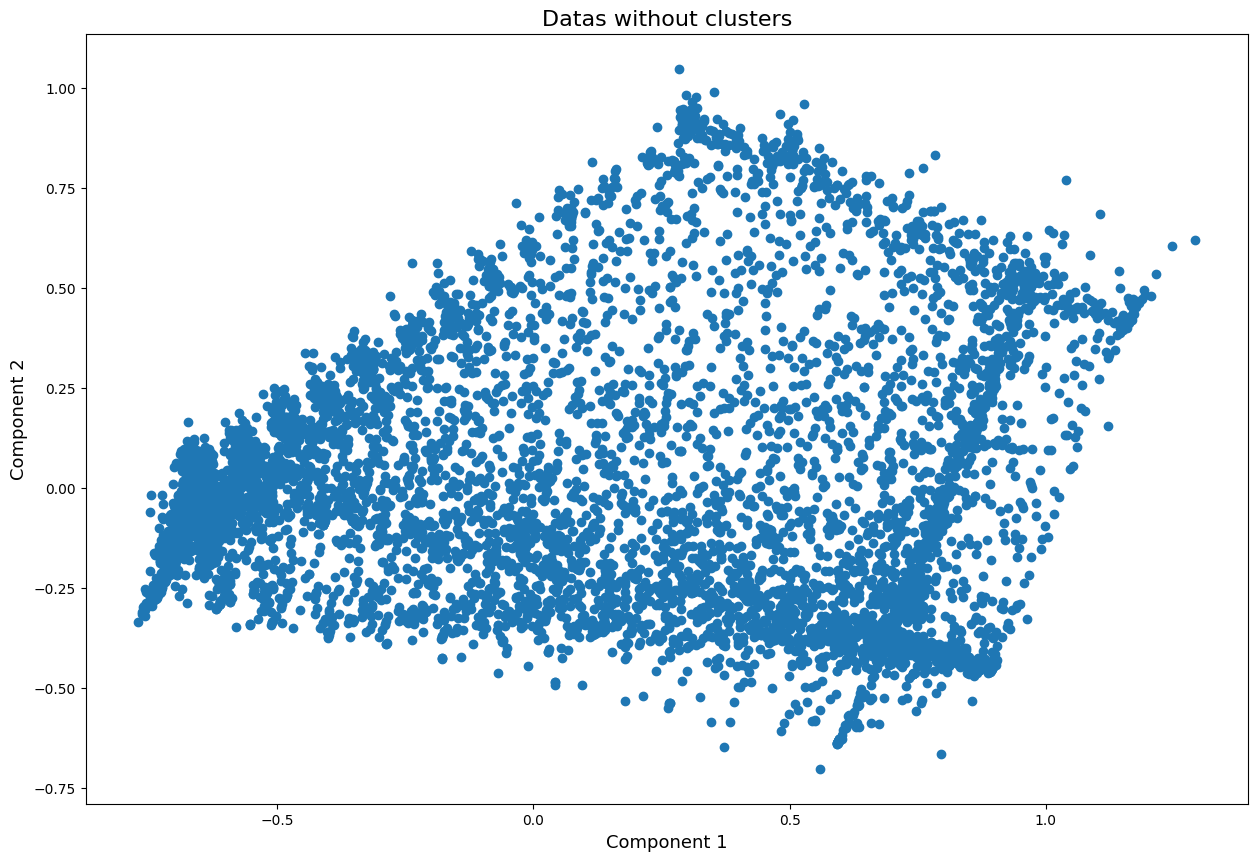

In [241]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(pca_results[:, 0], pca_results[:, 1])

ax.set_title('Datas without clusters', fontsize=16)

ax.set_xlabel('Component 1', fontsize=13)
ax.set_ylabel('Component 2', fontsize=13)

plt.show()

In [242]:
cluster_pipeline.steps.append(('Kmeans',Kmeans_(n_clusters=4)))

In [243]:
cluster_pipeline

Pipeline(steps=[('mean_inputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MINIMUM_PAYMENTS',
                                              'CREDIT_LIMIT'])),
                ('standard', ScalerDf(method='minmax')),
                ('PCA', PCA(n_components=2)),
                ('Kmeans', Kmeans_(n_clusters=4))])

In [244]:
cluster_pipeline.fit(cc_data)

Pipeline(steps=[('mean_inputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MINIMUM_PAYMENTS',
                                              'CREDIT_LIMIT'])),
                ('standard', ScalerDf(method='minmax')),
                ('PCA', PCA(n_components=2)),
                ('Kmeans', Kmeans_(n_clusters=4))])

In [245]:
cluster_results = cluster_pipeline.transform(cc_data)

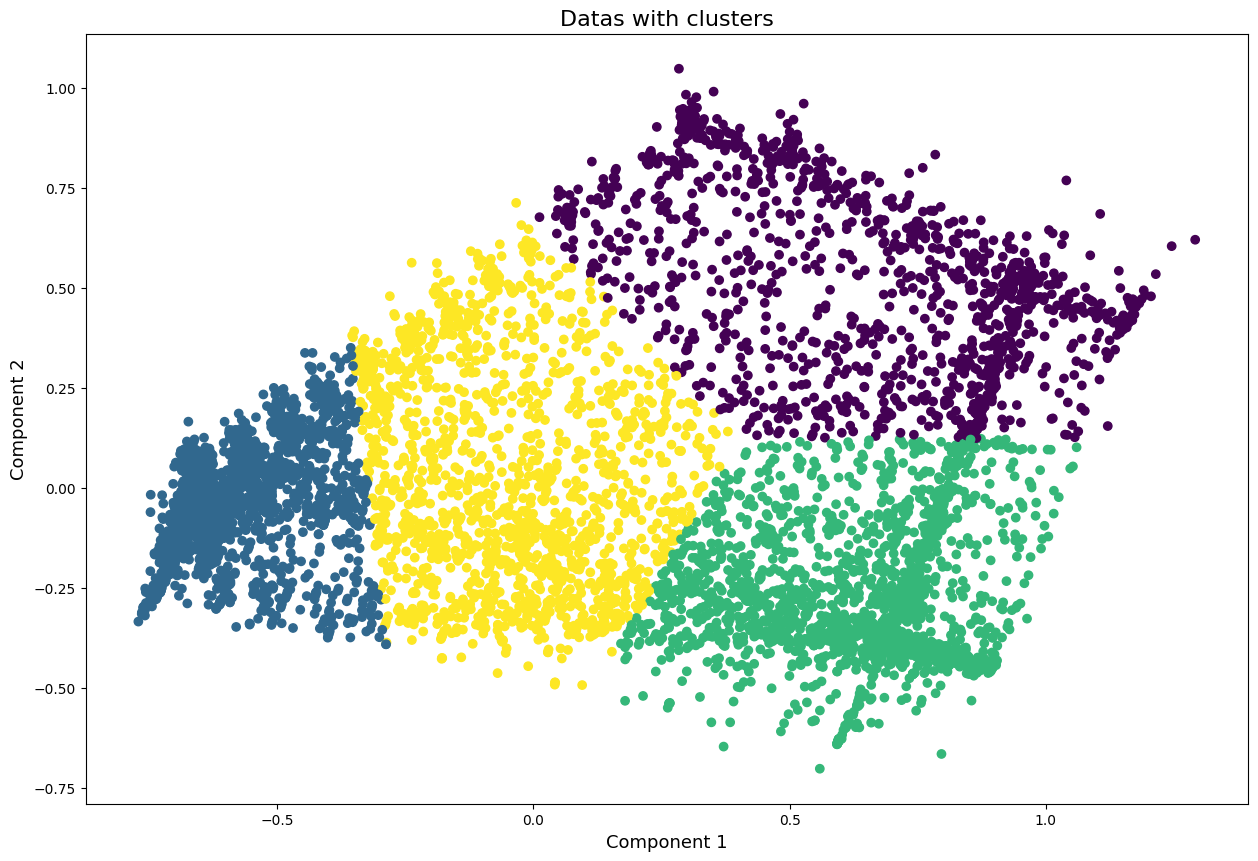

In [246]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(cluster_results[0], cluster_results[1], c=cluster_results['label'])

ax.set_title('Datas with clusters', fontsize=16)

ax.set_xlabel('Component 1', fontsize=13)
ax.set_ylabel('Component 2', fontsize=13)

plt.show()

In [247]:
cluster_pipeline.transform(test_data)

,0,1,label
0,0.269198,-0.341034,2
1,-0.672298,-0.067890,1
2,0.632487,-0.343800,2
3,0.613741,0.103518,2
4,0.905292,-0.415080,2
5,0.254143,-0.395801,2
6,-0.088059,-0.186207,3
7,0.549151,-0.487256,2
8,0.916534,-0.438494,2
9,-0.451173,0.230558,1


In [248]:
#joblib.dump(cluster_pipeline, 'cluster_pipeline.joblib')

In [249]:
import gradio as gr

In [250]:
cc_data.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [251]:
def predict(data):
    output = cluster_pipeline.transform(data)
    label = output['label']
    return label

In [252]:
cc_data.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [260]:
def sentence_builder(BALANCE, BALANCE_FREQUENCY, PURCHASES, ONEOFF_PURCHASES,
       INSTALLMENTS_PURCHASES, CASH_ADVANCE, PURCHASES_FREQUENCY,
       ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY,
       CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX, PURCHASES_TRX,
       CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT,
       TENURE):
    ls = [BALANCE, BALANCE_FREQUENCY, PURCHASES, ONEOFF_PURCHASES,
       INSTALLMENTS_PURCHASES, CASH_ADVANCE, PURCHASES_FREQUENCY,
       ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY,
       CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX, PURCHASES_TRX,
       CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT,
       TENURE]
    ls_df = pd.DataFrame(ls).T
    ls_df.columns = cc_data.columns
   
    df_transform = cluster_pipeline.transform(ls_df)
    cluster = df_transform['label'][0]
    return f'El individuo pertenece al cluster {cluster}'



demo = gr.Interface(
    sentence_builder,
     [gr.Number(value=cc_data[column][0]) for column in cc_data.columns],
    "text")

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7876

To create a public link, set `share=True` in `launch()`.


In [261]:
cc_data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C19136,893.949463,0.857143,958.80,958.80,0.00,566.910978,0.571429,0.571429,0.000000,0.142857,2,22,1200.0,590.785658,624.530535,0.000000,7
C19137,1117.594403,1.000000,291.62,0.00,291.62,1596.771919,1.000000,0.000000,0.857143,0.142857,2,7,2000.0,74.055925,382.846205,0.000000,7
C19138,328.686581,1.000000,2806.78,2588.53,218.25,0.000000,0.857143,0.714286,0.285714,0.000000,0,26,1200.0,1796.886852,93.017466,0.250000,7


In [262]:
joblib.dump(cluster_pipeline, './../models/cluster_pipeline.joblib')

['./../models/cluster_pipeline.joblib']